Training debuging

In [1]:
import os

pwd=!cd ../ && echo ${PWD}/
os.environ['DATA_DIR'] = pwd[0] + "input"
base_output_path = "/home/storage_ntfs_1tb"

In [2]:
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import logging
import numpy as np
import pprint
import sys

from caffe2.python import workspace

from detectron.core.config import assert_and_infer_cfg
from detectron.core.config import cfg, merge_cfg_from_file, merge_cfg_from_list
from detectron.utils.logging import setup_logging
import detectron.utils.c2 as c2_utils
import detectron.utils.train

c2_utils.import_contrib_ops()
c2_utils.import_detectron_ops()

# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)


# Initialize C2
workspace.GlobalInit(
    ['caffe2', '--caffe2_log_level=2', '--caffe2_gpu_memory_tracking=1']
)
# Set up logging and load config options
logger = setup_logging("Training debugging")
logging.getLogger('detectron.roi_data.loader').setLevel(logging.INFO)


config_name = "debug_faster_rcnn_X-101-64x4d-FPN_1x"
cfg_file = "configs/open_images_v4/{}.yaml".format(config_name)

from datetime import datetime
now = datetime.now()

output_path = base_output_path + "/output-OpenImagesObjectDetections/{}/{}".format(config_name, now.strftime("%Y%m%d_%H%M"))
weights_path = "weights/Faster-RCNN-X-101-64x4d-FPN/model_final.pkl" 

opts = ["OUTPUT_DIR", output_path,
        "NUM_GPUS", "1",
        "DEBUG", "True",
        "TRAIN.WEIGHTS", weights_path,
        "TRAIN.SNAPSHOT_ITERS", "20000",
        "TRAIN.IMS_PER_BATCH", "16",
        "SOLVER.BASE_LR", "0.001",
        "SOLVER.GAMMA", "0.5",
        "SOLVER.WARM_UP_ITERS", "100",
        "DATA_LOADER.MINIBATCH_QUEUE_SIZE", "64",
        "DATA_LOADER.BLOBS_QUEUE_CAPACITY", "32"]     


if cfg_file is not None:
    merge_cfg_from_file(cfg_file)

if opts is not None:
    merge_cfg_from_list(opts)

assert_and_infer_cfg()
logger.info("Training with config")
# Note that while we set the numpy random seed network training will not be
# deterministic in general. There are sources of non-determinism that cannot
# be removed with a reasonble execution-speed tradeoff (such as certain
# non-deterministic cudnn functions).
np.random.seed(cfg.RNG_SEED)

Found Detectron ops lib: /usr/local/caffe2_build/lib/libcaffe2_detectron_ops_gpu.so
INFO <ipython-input-2-743121e2dd96>:  61: Training with config


In [3]:
# detectron.utils.train.train_model
from shutil import copyfile
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import logging
import numpy as np

import os

from caffe2.python import memonger
from caffe2.python import workspace

from detectron.core.config import cfg, get_output_dir
from detectron.datasets.roidb import combined_roidb_for_training
from detectron.modeling import model_builder
from detectron.utils import lr_policy
from detectron.utils.training_stats import TrainingStats
import detectron.utils.env as envu
import detectron.utils.net as nu

def create_model():
    """Build the model and look for saved model checkpoints in case we can
    resume from one.
    """
    logger = logging.getLogger("create_model")
    start_iter = 0
    checkpoints = {}
    output_dir = get_output_dir(cfg.TRAIN.DATASETS, training=True)
    weights_file = cfg.TRAIN.WEIGHTS

    logger.info('Building model: {}'.format(cfg.MODEL.TYPE))
    model = model_builder.create(cfg.MODEL.TYPE, train=True)
    if cfg.MEMONGER:
        optimize_memory(model)
    # Performs random weight initialization as defined by the model
    workspace.RunNetOnce(model.param_init_net)
    return model, weights_file, start_iter, checkpoints, output_dir


def optimize_memory(model):
    """Save GPU memory through blob sharing."""
    for device in range(cfg.NUM_GPUS):
        namescope = 'gpu_{}/'.format(device)
        losses = [namescope + l for l in model.losses]
        model.net._net = memonger.share_grad_blobs(
            model.net,
            losses,
            set(model.param_to_grad.values()),
            namescope,
            share_activations=cfg.MEMONGER_SHARE_ACTIVATIONS
        )


def setup_model_for_training(model, weights_file, output_dir):
    """Loaded saved weights and create the network in the C2 workspace."""
    logger = logging.getLogger("setup_model_for_training")
    add_model_training_inputs(model)

    if weights_file:
        # Override random weight initialization with weights from a saved model
        nu.initialize_gpu_from_weights_file(model, weights_file, gpu_id=0)
    # Even if we're randomly initializing we still need to synchronize
    # parameters across GPUs
    nu.broadcast_parameters(model)
    workspace.CreateNet(model.net)

    #logger.info('Outputs saved to: {:s}'.format(os.path.abspath(output_dir)))
    #dump_proto_files(model, output_dir)

    # Start loading mini-batches and enqueuing blobs
    model.roi_data_loader.register_sigint_handler()
    model.roi_data_loader.start(prefill=True)
    return output_dir


def add_model_training_inputs(model):
    """Load the training dataset and attach the training inputs to the model."""
    logger = logging.getLogger("add_model_training_inputs")
    logger.info('Loading dataset: {}'.format(cfg.TRAIN.DATASETS))
    roidb = combined_roidb_for_training(
        cfg.TRAIN.DATASETS, cfg.TRAIN.PROPOSAL_FILES
    )
    logger.info('{:d} roidb entries'.format(len(roidb)))
    model_builder.add_training_inputs(model, roidb=roidb)

In [4]:
logger = logging.getLogger("Training with config")
model, weights_file, start_iter, checkpoints, output_dir = create_model()

setup_model_for_training(model, weights_file, output_dir)
training_stats = TrainingStats(model, None)

INFO <ipython-input-3-c870c21228ab>:  30: Building model: generalized_rcnn
WARNING cnn.py:  40: [====DEPRECATE WARNING====]: you are creating an object from CNNModelHelper class which will be deprecated soon. Please use ModelHelper object with brew module. For more information, please refer to caffe2.ai and python/brew.py, python/brew_test.py for more information.
WARNING memonger.py:  70: NOTE: Executing memonger to optimize gradient memory
INFO memonger.py: 112: Memonger memory optimization took 0.00471210479736 secs
INFO <ipython-input-3-c870c21228ab>:  78: Loading dataset: ('open_images_v4_test',)
loading annotations into memory...
Done (t=6.28s)
creating index...
index created!
INFO roidb.py:  49: Appending horizontally-flipped training examples...
INFO roidb.py:  51: Loaded dataset: open_images_v4_test
INFO roidb.py: 135: Filtered 0 roidb entries: 215974 -> 215974
INFO roidb.py:  67: Computing bounding-box regression targets...
INFO roidb.py:  69: done
INFO <ipython-input-3-c870c

Traceback (most recent call last):
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/detectron_source/detectron/utils/coordinator.py", line 50, in stop_on_exception
    yield
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/detectron_source/detectron/roi_data/loader.py", line 122, in enqueue_blobs_thread
    self.enqueue_blobs(gpu_id, blob_names, blobs.values())
  File "/home/working_directory/ml/kaggle/OpenImagesObjectDetection/detectron_source/detectron/roi_data/loader.py", line 191, in enqueue_blobs
    workspace.FeedBlob(blob_name, blob, device_option=dev)
  File "/usr/local/caffe2_build/caffe2/python/workspace.py", line 322, in FeedBlob
    return C.feed_blob(name, arr, StringifyProto(device_option))
RuntimeError: [enforce fail at context_gpu.cu:343] error == cudaSuccess. 2 vs 0. Error at: /var/lib/jenkins/workspace/caffe2/core/context_gpu.cu:343: out of memory 


INFO loader.py: 113: Stopping mini-batch loading thread
INFO loader.py: 113: Stopping mini-batch loading thread
INFO loader.py: 113: Stopping mini-batch loading thread
INFO loader.py: 113: Stopping mini-batch loading thread


### Dataflow 

Data is provided to model with `detectron.roi_data.loader.RoIDataLoader`:
```
Outline of the data loader design:

loader thread\
loader thread \                    / GPU 1 enqueue thread -> feed -> EnqueueOp
...           -> minibatch queue ->  ...
loader thread /                    \ GPU N enqueue thread -> feed -> EnqueueOp
loader thread/

<---------------------------- CPU -----------------------------|---- GPU ---->

A pool of loader threads construct minibatches that are put onto the shared
minibatch queue. Each GPU has an enqueue thread that pulls a minibatch off the
minibatch queue, feeds the minibatch blobs into the workspace, and then runs
an EnqueueBlobsOp to place the minibatch blobs into the GPU's blobs queue.
During each fprop the first thing the network does is run a DequeueBlobsOp
in order to populate the workspace with the blobs from a queued minibatch.
```

In [5]:
import matplotlib.pylab as plt
%matplotlib inline

In [6]:
blobs = model.roi_data_loader.get_next_minibatch()

In [7]:
len(blobs), blobs.keys()

(23,
 [u'rpn_labels_int32_wide_fpn4',
  u'rpn_labels_int32_wide_fpn5',
  u'rpn_labels_int32_wide_fpn6',
  u'rpn_labels_int32_wide_fpn2',
  u'rpn_labels_int32_wide_fpn3',
  u'rpn_bbox_targets_wide_fpn2',
  u'rpn_bbox_targets_wide_fpn3',
  u'rpn_bbox_targets_wide_fpn6',
  u'rpn_bbox_targets_wide_fpn4',
  u'rpn_bbox_targets_wide_fpn5',
  u'roidb',
  u'data',
  u'im_info',
  u'rpn_bbox_outside_weights_wide_fpn3',
  u'rpn_bbox_outside_weights_wide_fpn2',
  u'rpn_bbox_outside_weights_wide_fpn6',
  u'rpn_bbox_outside_weights_wide_fpn5',
  u'rpn_bbox_outside_weights_wide_fpn4',
  u'rpn_bbox_inside_weights_wide_fpn6',
  u'rpn_bbox_inside_weights_wide_fpn5',
  u'rpn_bbox_inside_weights_wide_fpn4',
  u'rpn_bbox_inside_weights_wide_fpn3',
  u'rpn_bbox_inside_weights_wide_fpn2'])

In [8]:
type(blobs['rpn_labels_int32_wide_fpn3']), blobs['rpn_labels_int32_wide_fpn3'].shape

(numpy.ndarray, (16, 3, 168, 168))

In [9]:
type(blobs['rpn_bbox_targets_wide_fpn3']), blobs['rpn_bbox_targets_wide_fpn3'].shape

(numpy.ndarray, (16, 12, 168, 168))

In [10]:
type(blobs['roidb']), blobs['roidb'].shape

(numpy.ndarray, (22947,))

In [11]:
type(blobs['data']), blobs['data'].shape

(numpy.ndarray, (16, 3, 800, 1344))

In [12]:
# im = blobs['data'][0, ...].transpose([1, 2, 0])
# im = (255.0 * (im - im.min()) / (im.max() - im.min())).astype('uint8')

# plt.imshow(im)

In [13]:
from detectron.utils.blob import deserialize

minimal_roidb = deserialize(blobs['roidb'])

In [14]:
minimal_roidb

[{u'box_to_gt_ind_map': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
  u'boxes': array([[   0.,   49.,  205.,  325.],
         [  33.,    0.,  126.,   31.],
         [ 806.,    4.,  869.,   72.],
         [ 830.,    0., 1021.,   90.],
         [ 568.,  163.,  621.,  179.],
         [   0.,   47.,  142.,  397.],
         [  30.,   52., 1012.,  543.],
         [  36.,    0.,  130.,   42.],
         [ 153.,    0.,  438.,   71.],
         [ 476.,    0.,  813.,   80.]], dtype=float32),
  u'gt_classes': array([103, 103, 103, 103, 414, 571, 571, 571, 571, 571], dtype=int32),
  u'gt_overlaps': <10x602 sparse matrix of type '<type 'numpy.float32'>'
  	with 10 stored elements in Compressed Sparse Row format>,
  u'has_visible_keypoints': False,
  u'is_crowd': array([False, False, False, False, False, False, False, False, False,
         False]),
  u'seg_areas': array([ 57062.,   3008.,   4416.,  17472.,    918.,  50193., 483636.,
           4085.,  20592.,  27378.], dtype=float32),
  u'seg

In [15]:
len(model.roi_data_loader._roidb)

215974

In [17]:
import tqdm

n = len(model.roi_data_loader._roidb) / 16

for i in tqdm.tqdm(range(354, n)):
    blobs = model.roi_data_loader.get_next_minibatch()


  2%|▏         | 287/13144 [04:55<3:40:32,  1.03s/it]


  4%|▍         | 573/13144 [09:51<3:36:18,  1.03s/it]


  7%|▋         | 859/13144 [14:47<3:31:38,  1.03s/it]


  9%|▊         | 1143/13144 [19:41<3:26:48,  1.03s/it]


 11%|█         | 1425/13144 [24:35<3:22:16,  1.04s/it]


 13%|█▎        | 1707/13144 [29:26<3:17:14,  1.03s/it]


 15%|█▌        | 1989/13144 [34:19<3:12:29,  1.04s/it]


 17%|█▋        | 2271/13144 [39:10<3:07:34,  1.04s/it]


 19%|█▉        | 2553/13144 [44:02<3:02:43,  1.04s/it]


 22%|██▏       | 2835/13144 [48:52<2:57:43,  1.03s/it]


 24%|██▎       | 3093/13144 [53:20<2:53:21,  1.03s/it]

KeyboardInterrupt: 

Iterations

In [17]:
cur_iter = 0

In [ ]:
training_stats.IterTic()
lr = model.UpdateWorkspaceLr(cur_iter, lr_policy.get_lr_at_iter(cur_iter))
workspace.RunNet(model.net.Proto().name)
training_stats.IterToc()
training_stats.UpdateIterStats()
training_stats.LogIterStats(cur_iter, lr)
cur_iter += 1

In [14]:
# proto = model.net.Proto()

# from caffe2.python import net_drawer

# from IPython import display
# graph = net_drawer.GetPydotGraph(proto.op, "Faster-RCNN", rankdir="TD")

Complete check

In [ ]:
for cur_iter in range(start_iter, cfg.SOLVER.MAX_ITER):
    training_stats.IterTic()
    lr = model.UpdateWorkspaceLr(cur_iter, lr_policy.get_lr_at_iter(cur_iter))
    workspace.RunNet(model.net.Proto().name)
    if cur_iter == start_iter:
        nu.print_net(model)
    training_stats.IterToc()
    training_stats.UpdateIterStats()
    training_stats.LogIterStats(cur_iter, lr)

    if cur_iter == start_iter + training_stats.LOG_PERIOD:
        # Reset the iteration timer to remove outliers from the first few
        # SGD iterations
        training_stats.ResetIterTimer()

    if np.isnan(training_stats.iter_total_loss):
        logger.critical('Loss is NaN, exiting...')
        logger.critical('Losses and metrics: {}'
            .format([training_stats.losses_and_metrics[k] for k in training_stats.model.losses]))
        model.roi_data_loader.shutdown()
        envu.exit_on_error()

#     for gpu_id in range(cfg.NUM_GPUS):
#         tblogger.append_image("gpu_{}/data".format(gpu_id))

INFO detector.py: 479: Changing learning rate 0.000000 -> 0.000333 at iter 0
INFO net.py: 220: Printing model: generalized_rcnn
INFO net.py: 257: data                        : (1, 3, 800, 1184)    => conv1                       : (1, 64, 400, 592)    ------- (op: Conv)
INFO net.py: 257: conv1                       : (1, 64, 400, 592)    => conv1                       : (1, 64, 400, 592)    ------- (op: AffineChannel)
INFO net.py: 257: conv1                       : (1, 64, 400, 592)    => conv1                       : (1, 64, 400, 592)    ------- (op: Relu)
INFO net.py: 257: conv1                       : (1, 64, 400, 592)    => pool1                       : (1, 64, 200, 296)    ------- (op: MaxPool)
INFO net.py: 257: pool1                       : (1, 64, 200, 296)    => res2_0_branch2a             : (1, 256, 200, 296)   ------- (op: Conv)
INFO net.py: 257: res2_0_branch2a             : (1, 256, 200, 296)   => res2_0_branch2a             : (1, 256, 200, 296)   ------- (op: AffineChannel)

INFO net.py: 257: res3_1_branch2b             : (1, 512, 100, 148)   => res3_1_branch2b             : (1, 512, 100, 148)   ------- (op: AffineChannel)
INFO net.py: 257: res3_1_branch2b             : (1, 512, 100, 148)   => res3_1_branch2b             : (1, 512, 100, 148)   ------- (op: Relu)
INFO net.py: 257: res3_1_branch2b             : (1, 512, 100, 148)   => res3_1_branch2c             : (1, 512, 100, 148)   ------- (op: Conv)
INFO net.py: 257: res3_1_branch2c             : (1, 512, 100, 148)   => res3_1_branch2c_bn          : (1, 512, 100, 148)   ------- (op: AffineChannel)
INFO net.py: 257: res3_1_branch2c_bn          : (1, 512, 100, 148)   => res3_1_branch2c_bn          : (1, 512, 100, 148)   ------- (op: Sum)
INFO net.py: 257: res3_0_branch2c_bn          : (1, 512, 100, 148)   => res3_1_branch2c_bn          : (1, 512, 100, 148)   ------|
INFO net.py: 257: res3_1_branch2c_bn          : (1, 512, 100, 148)   => res3_1_branch2c_bn          : (1, 512, 100, 148)   ------- (op: Relu)


INFO net.py: 257: res4_2_branch2b             : (1, 1024, 50, 74)    => res4_2_branch2b             : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_2_branch2b             : (1, 1024, 50, 74)    => res4_2_branch2c             : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.py: 257: res4_2_branch2c             : (1, 1024, 50, 74)    => res4_2_branch2c_bn          : (1, 1024, 50, 74)    ------- (op: AffineChannel)
INFO net.py: 257: res4_2_branch2c_bn          : (1, 1024, 50, 74)    => res4_2_branch2c_bn          : (1, 1024, 50, 74)    ------- (op: Sum)
INFO net.py: 257: res4_1_branch2c_bn          : (1, 1024, 50, 74)    => res4_2_branch2c_bn          : (1, 1024, 50, 74)    ------|
INFO net.py: 257: res4_2_branch2c_bn          : (1, 1024, 50, 74)    => res4_2_branch2c_bn          : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_2_branch2c_bn          : (1, 1024, 50, 74)    => res4_3_branch2a             : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.

INFO net.py: 257: res4_7_branch2c_bn          : (1, 1024, 50, 74)    => res4_7_branch2c_bn          : (1, 1024, 50, 74)    ------- (op: Sum)
INFO net.py: 257: res4_6_branch2c_bn          : (1, 1024, 50, 74)    => res4_7_branch2c_bn          : (1, 1024, 50, 74)    ------|
INFO net.py: 257: res4_7_branch2c_bn          : (1, 1024, 50, 74)    => res4_7_branch2c_bn          : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_7_branch2c_bn          : (1, 1024, 50, 74)    => res4_8_branch2a             : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.py: 257: res4_8_branch2a             : (1, 1024, 50, 74)    => res4_8_branch2a             : (1, 1024, 50, 74)    ------- (op: AffineChannel)
INFO net.py: 257: res4_8_branch2a             : (1, 1024, 50, 74)    => res4_8_branch2a             : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_8_branch2a             : (1, 1024, 50, 74)    => res4_8_branch2b             : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.

INFO net.py: 257: res4_12_branch2c_bn         : (1, 1024, 50, 74)    => res4_13_branch2a            : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.py: 257: res4_13_branch2a            : (1, 1024, 50, 74)    => res4_13_branch2a            : (1, 1024, 50, 74)    ------- (op: AffineChannel)
INFO net.py: 257: res4_13_branch2a            : (1, 1024, 50, 74)    => res4_13_branch2a            : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_13_branch2a            : (1, 1024, 50, 74)    => res4_13_branch2b            : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.py: 257: res4_13_branch2b            : (1, 1024, 50, 74)    => res4_13_branch2b            : (1, 1024, 50, 74)    ------- (op: AffineChannel)
INFO net.py: 257: res4_13_branch2b            : (1, 1024, 50, 74)    => res4_13_branch2b            : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_13_branch2b            : (1, 1024, 50, 74)    => res4_13_branch2c            : (1, 1024, 50, 74)    -------

INFO net.py: 257: res4_18_branch2a            : (1, 1024, 50, 74)    => res4_18_branch2b            : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.py: 257: res4_18_branch2b            : (1, 1024, 50, 74)    => res4_18_branch2b            : (1, 1024, 50, 74)    ------- (op: AffineChannel)
INFO net.py: 257: res4_18_branch2b            : (1, 1024, 50, 74)    => res4_18_branch2b            : (1, 1024, 50, 74)    ------- (op: Relu)
INFO net.py: 257: res4_18_branch2b            : (1, 1024, 50, 74)    => res4_18_branch2c            : (1, 1024, 50, 74)    ------- (op: Conv)
INFO net.py: 257: res4_18_branch2c            : (1, 1024, 50, 74)    => res4_18_branch2c_bn         : (1, 1024, 50, 74)    ------- (op: AffineChannel)
INFO net.py: 257: res4_18_branch2c_bn         : (1, 1024, 50, 74)    => res4_18_branch2c_bn         : (1, 1024, 50, 74)    ------- (op: Sum)
INFO net.py: 257: res4_17_branch2c_bn         : (1, 1024, 50, 74)    => res4_18_branch2c_bn         : (1, 1024, 50, 74)    ------|


INFO net.py: 257: res5_0_branch2b             : (1, 2048, 25, 37)    => res5_0_branch2c             : (1, 2048, 25, 37)    ------- (op: Conv)
INFO net.py: 257: res5_0_branch2c             : (1, 2048, 25, 37)    => res5_0_branch2c_bn          : (1, 2048, 25, 37)    ------- (op: AffineChannel)
INFO net.py: 257: res4_22_sum                 : (1, 1024, 50, 74)    => res5_0_branch1              : (1, 2048, 25, 37)    ------- (op: Conv)
INFO net.py: 257: res5_0_branch1              : (1, 2048, 25, 37)    => res5_0_branch1_bn           : (1, 2048, 25, 37)    ------- (op: AffineChannel)
INFO net.py: 257: res5_0_branch2c_bn          : (1, 2048, 25, 37)    => res5_0_branch2c_bn          : (1, 2048, 25, 37)    ------- (op: Sum)
INFO net.py: 257: res5_0_branch1_bn           : (1, 2048, 25, 37)    => res5_0_branch2c_bn          : (1, 2048, 25, 37)    ------|
INFO net.py: 257: res5_0_branch2c_bn          : (1, 2048, 25, 37)    => res5_0_branch2c_bn          : (1, 2048, 25, 37)    ------- (op: Relu)


INFO net.py: 257: rpn_bbox_pred_fpn2          : (1, 12, 200, 296)    => rpn_rois_fpn2               : (717, 5)             ------|
INFO net.py: 257: im_info                     : (1, 3)               => rpn_rois_fpn2               : (717, 5)             ------|
INFO net.py: 257: fpn_res3_3_sum              : (1, 256, 100, 148)   => conv_rpn_fpn3               : (1, 256, 100, 148)   ------- (op: Conv)
INFO net.py: 257: conv_rpn_fpn3               : (1, 256, 100, 148)   => conv_rpn_fpn3               : (1, 256, 100, 148)   ------- (op: Relu)
INFO net.py: 257: conv_rpn_fpn3               : (1, 256, 100, 148)   => rpn_cls_logits_fpn3         : (1, 3, 100, 148)     ------- (op: Conv)
INFO net.py: 257: conv_rpn_fpn3               : (1, 256, 100, 148)   => rpn_bbox_pred_fpn3          : (1, 12, 100, 148)    ------- (op: Conv)
INFO net.py: 257: rpn_cls_logits_fpn3         : (1, 3, 100, 148)     => rpn_cls_probs_fpn3          : (1, 3, 100, 148)     ------- (op: Sigmoid)
INFO net.py: 257: rpn_cls

INFO net.py: 257: rpn_labels_int32_fpn2       : (1, 3, 200, 296)     => loss_rpn_cls_fpn2           : ()                   ------|
INFO net.py: 257: rpn_bbox_pred_fpn2          : (1, 12, 200, 296)    => loss_rpn_bbox_fpn2          : ()                   ------- (op: SmoothL1Loss)
INFO net.py: 257: rpn_bbox_targets_fpn2       : (1, 12, 200, 296)    => loss_rpn_bbox_fpn2          : ()                   ------|
INFO net.py: 257: rpn_bbox_inside_weights_fpn2: (1, 12, 200, 296)    => loss_rpn_bbox_fpn2          : ()                   ------|
INFO net.py: 257: rpn_bbox_outside_weights_fpn2: (1, 12, 200, 296)    => loss_rpn_bbox_fpn2          : ()                   ------|
INFO net.py: 257: rpn_labels_int32_wide_fpn3  : (1, 3, 168, 168)     => rpn_labels_int32_fpn3       : (1, 3, 100, 148)     ------- (op: SpatialNarrowAs)
INFO net.py: 257: rpn_cls_logits_fpn3         : (1, 3, 100, 148)     => rpn_labels_int32_fpn3       : (1, 3, 100, 148)     ------|
INFO net.py: 257: rpn_bbox_targets_wide_f

INFO net.py: 257: rpn_bbox_targets_fpn6       : (1, 12, 13, 19)      => loss_rpn_bbox_fpn6          : ()                   ------|
INFO net.py: 257: rpn_bbox_inside_weights_fpn6: (1, 12, 13, 19)      => loss_rpn_bbox_fpn6          : ()                   ------|
INFO net.py: 257: rpn_bbox_outside_weights_fpn6: (1, 12, 13, 19)      => loss_rpn_bbox_fpn6          : ()                   ------|
INFO net.py: 257: fpn_res2_2_sum              : (1, 256, 200, 296)   => roi_feat_fpn2               : (304, 256, 7, 7)     ------- (op: RoIAlign)
INFO net.py: 257: rois_fpn2                   : (304, 5)             => roi_feat_fpn2               : (304, 256, 7, 7)     ------|
INFO net.py: 257: fpn_res3_3_sum              : (1, 256, 100, 148)   => roi_feat_fpn3               : (118, 256, 7, 7)     ------- (op: RoIAlign)
INFO net.py: 257: rois_fpn3                   : (118, 5)             => roi_feat_fpn3               : (118, 256, 7, 7)     ------|
INFO net.py: 257: fpn_res4_22_sum             : (1, 

json_stats: {"accuracy_cls": 0.948242, "eta": "1 day, 9:30:45", "iter": 160, "loss": 0.695159, "loss_bbox": 0.124931, "loss_cls": 0.459859, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.000015, "loss_rpn_bbox_fpn6": 0.019738, "loss_rpn_cls_fpn2": 0.005909, "loss_rpn_cls_fpn3": 0.004476, "loss_rpn_cls_fpn4": 0.005290, "loss_rpn_cls_fpn5": 0.004924, "loss_rpn_cls_fpn6": 0.000042, "lr": 0.001000, "mb_qsize": 8, "mem": 5527, "time": 0.201130}
json_stats: {"accuracy_cls": 0.936523, "eta": "1 day, 9:30:10", "iter": 180, "loss": 0.652164, "loss_bbox": 0.149513, "loss_cls": 0.471561, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.000595, "loss_rpn_bbox_fpn6": 0.013909, "loss_rpn_cls_fpn2": 0.008737, "loss_rpn_cls_fpn3": 0.006883, "loss_rpn_cls_fpn4": 0.000579, "loss_rpn_cls_fpn5": 0.002923, "loss_rpn_cls_fpn6": 0.000210, "lr": 0.001000, "mb_qsize": 

json_stats: {"accuracy_cls": 0.939453, "eta": "1 day, 9:34:22", "iter": 480, "loss": 0.616385, "loss_bbox": 0.125995, "loss_cls": 0.456655, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.000511, "loss_rpn_bbox_fpn6": 0.007725, "loss_rpn_cls_fpn2": 0.015016, "loss_rpn_cls_fpn3": 0.010300, "loss_rpn_cls_fpn4": 0.005819, "loss_rpn_cls_fpn5": 0.003748, "loss_rpn_cls_fpn6": 0.000477, "lr": 0.001000, "mb_qsize": 8, "mem": 5529, "time": 0.201599}
json_stats: {"accuracy_cls": 0.958984, "eta": "1 day, 9:35:58", "iter": 500, "loss": 0.506502, "loss_bbox": 0.115039, "loss_cls": 0.319909, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.001507, "loss_rpn_bbox_fpn6": 0.009541, "loss_rpn_cls_fpn2": 0.017344, "loss_rpn_cls_fpn3": 0.004283, "loss_rpn_cls_fpn4": 0.006362, "loss_rpn_cls_fpn5": 0.000526, "loss_rpn_cls_fpn6": 0.000079, "lr": 0.001000, "mb_qsize": 

json_stats: {"accuracy_cls": 0.871094, "eta": "1 day, 9:45:04", "iter": 800, "loss": 0.963081, "loss_bbox": 0.268263, "loss_cls": 0.596206, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.003312, "loss_rpn_bbox_fpn6": 0.018174, "loss_rpn_cls_fpn2": 0.006090, "loss_rpn_cls_fpn3": 0.004625, "loss_rpn_cls_fpn4": 0.006349, "loss_rpn_cls_fpn5": 0.000555, "loss_rpn_cls_fpn6": 0.000082, "lr": 0.001000, "mb_qsize": 8, "mem": 5530, "time": 0.202778}
json_stats: {"accuracy_cls": 0.932617, "eta": "1 day, 9:45:48", "iter": 820, "loss": 0.555776, "loss_bbox": 0.123828, "loss_cls": 0.301506, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000312, "loss_rpn_bbox_fpn5": 0.000000, "loss_rpn_bbox_fpn6": 0.012844, "loss_rpn_cls_fpn2": 0.001640, "loss_rpn_cls_fpn3": 0.002513, "loss_rpn_cls_fpn4": 0.004804, "loss_rpn_cls_fpn5": 0.000843, "loss_rpn_cls_fpn6": 0.000100, "lr": 0.001000, "mb_qsize": 

json_stats: {"accuracy_cls": 0.927734, "eta": "1 day, 9:48:25", "iter": 1120, "loss": 0.587629, "loss_bbox": 0.107519, "loss_cls": 0.377178, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.000000, "loss_rpn_bbox_fpn6": 0.019543, "loss_rpn_cls_fpn2": 0.003386, "loss_rpn_cls_fpn3": 0.003992, "loss_rpn_cls_fpn4": 0.003546, "loss_rpn_cls_fpn5": 0.002267, "loss_rpn_cls_fpn6": 0.000443, "lr": 0.001000, "mb_qsize": 8, "mem": 5530, "time": 0.203222}
json_stats: {"accuracy_cls": 0.966797, "eta": "1 day, 9:49:05", "iter": 1140, "loss": 0.354719, "loss_bbox": 0.077447, "loss_cls": 0.256304, "loss_rpn_bbox_fpn2": 0.000000, "loss_rpn_bbox_fpn3": 0.000000, "loss_rpn_bbox_fpn4": 0.000000, "loss_rpn_bbox_fpn5": 0.000305, "loss_rpn_bbox_fpn6": 0.009357, "loss_rpn_cls_fpn2": 0.001548, "loss_rpn_cls_fpn3": 0.001228, "loss_rpn_cls_fpn4": 0.001980, "loss_rpn_cls_fpn5": 0.001715, "loss_rpn_cls_fpn6": 0.000201, "lr": 0.001000, "mb_qsize"

Probably data corruption problem:
```
Corrupt JPEG data: bad Huffman code
```

In [1]:
import cv2
import os
import glob

In [2]:
img_list = glob.glob("/home/fast_storage/OpenImagesDataset/as_mscoco/test/*.jpg")
len(img_list)

125436

In [3]:
!rm -R test_viz/

In [26]:
from image_dataset_viz import DatasetExporter
from PIL import Image


def read_img_fn(path):
    img = cv2.imread(path)
    assert img.ndim == 3, path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img).convert("RGB")


de = DatasetExporter(read_img_fn, img_id_fn=lambda p: os.path.basename(p))

In [27]:
de.export(img_list[-2612:-2600], None, output_folder='test_viz', filename_prefix='test')



  0%|          |0/12[00:00<?,?it/s]

100%|##########|12/12[00:00<00:00,34.22it/s]

In [28]:
import tqdm

try:
    for p in tqdm.tqdm(img_list[-2612:-2600]):
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
        print(p, img.shape)
except RuntimeWarning:
    print(p)



  0%|          | 0/12 [00:00<?, ?it/s]

 50%|█████     | 6/12 [00:00<00:00, 54.45it/s]

100%|██████████| 12/12 [00:00<00:00, 68.02it/s]

('/home/fast_storage/OpenImagesDataset/as_mscoco/test/a54f93c489fad430.jpg', (768, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/1ea1da6ed2373809.jpg', (681, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/75b6c01aca0fc1e2.jpg', (683, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/38050f3430ee705c.jpg', (681, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/e9130800f7e6c362.jpg', (1024, 775, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/2721086b9c86bd90.jpg', (731, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/fd9580e54bd021f5.jpg', (1024, 768, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/ebac6e526a35c65a.jpg', (768, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/7a9b49a8d31b02c4.jpg', (1024, 768, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/582af0fe86bcaea1.jpg', (768, 1024, 3))
('/home/fast_storage/OpenImagesDataset/as_mscoco/test/e2714e690b96af82

In [39]:
img = Image.open("/home/fast_storage/OpenImagesDataset/as_mscoco/test/a54f93c489fad430.jpg")
type(img)

PIL.JpegImagePlugin.JpegImageFile

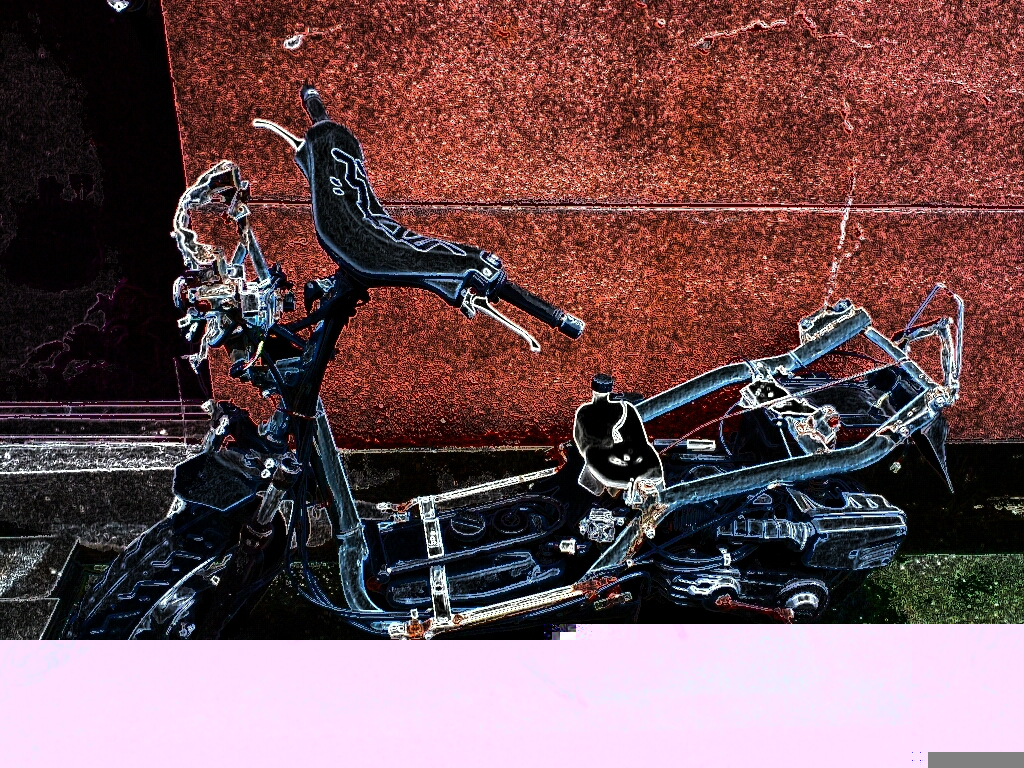

In [40]:
img.convert('RGB')

In [37]:
img.verify??

In [ ]:
import json


data = None
with open("/home/fast_storage/OpenImagesDataset/as_mscoco/annotations/test.json", 'r') as h:
    data = json.load(h)

In [40]:
# import tqdm
# from image_dataset_viz.dataset_exporter import check_image_type

# try:
#     for p in tqdm.tqdm(img_list):
#         img = Image.open(p)
#         img.verify()
# except:
#     print(p)


100%|██████████| 125436/125436 [00:08<00:00, 15178.46it/s]

In [18]:
img = cv2.imread("/home/fast_storage/OpenImagesDataset/as_mscoco/test/464f3565913121a9.jpg")

In [21]:
img.shape

(1024, 967, 3)